# Project 1: computing all kinematic informations of a real manipulator

In this project (and the next ones), we will build all the necessary various functionalities for realistic robot manipulators. This first project aims to build the core fonctions (basic homogeneous transforms, twists, forward kinematics and Jacobians) that will be a foundation for all subsequent algorithms.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a written answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.


## The robot

We will use a model of the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa). This robot has 7 revolute joints and its kinematics is described in the picture below:

![](https://raw.githubusercontent.com/righetti/ROB6003/143afa17d7eb1af79c3f6ce034973a1774da5d42/Project1/kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Setup

Run the cell below only once when resetting the runtime in Colab - this will not do anything when running on a local Jupyter Notebook.

In [53]:
## check if we are in Google Colab
try:
    import google.colab
    RUNNING_IN_COLAB = True
    print('detected Colab - setting up environment')
    # then we need to install the conda environment
    try:
        import condacolab
        condacolab.check()
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
except:
    RUNNING_IN_COLAB = False

In [54]:
# after installing condalab, the runtime restarts
# -> need to check for colab env once more here
try:
    import google.colab
    RUNNING_IN_COLAB = True
except Exception as e:
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    try:
        # Check if packages are installed or not. If not, install them.
        import pinocchio
    except:
        # Install pinocchio, meschat-python 
        !conda install pinocchio meshcat-python
       
    # get the class repo - first check if it exists
    import os, sys
    if not os.path.isdir('/content/ROB6003/Project1'):
      print('cloning LAB repository')
      os.chdir('/content')
      !git clone https://github.com/righetti/ROB6003.git
      print('cloning done')
    else:
      print('lab repos was found, skipping cloning')
    print('done configuring for Colab')
    sys.path.append('/content/ROB6003/Project1/')
    os.chdir('/content/ROB6003/Project1/')
    print('done adding system path and changing directory.')


# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [55]:
import numpy as np
import robot_visualizer
import time
import scipy as sp

import matplotlib.pyplot as plt

robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7001/static/


D:\User\anaconda\lib\site-packages\pinocchio\shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


# Displaying an arbitrary configuration

You can use the following function to display arbitrary configurations of the robot

In [56]:
# here we display an arbitrary configuration of the robot
q = np.random.sample([7])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q)

we show the configuration for the angles [0.12248259 0.96385225 0.69751466 0.78386765 0.29015078 0.67388545
 0.75278921]


In [57]:
# Here are some other basic functions writen before.
import numpy as np
import math
from scipy.linalg import expm
from scipy.linalg import logm

# 1.from a → [a] ( 3 x 3 )
def GetMatrixForm(w):

    bnw = np.array([
        [0      , -w[2,0] , w[1,0] ],
        [w[2,0] , 0       , -w[0,0]],
        [-w[1,0], w[0,0]  , 0      ]
        ])
    
    return bnw

# 2.from [a] → a ( 3 x 1 )   
def GetVector(mw):

    w=([
    [mw[2,1]],
    [mw[0,2]],
    [mw[1,0]]
    ])

    return w

# 3.Rot( axis, theta )
# Counterclockwise means positive angle
def Rot( axis, theta ):

    if axis == 'x':

        R = np.array([
            [1, 0 ,0],
            [0, math.cos(theta), -math.sin(theta)],
            [0, math.sin(theta), math.cos(theta)]
        ])

        return R
    
    elif axis == 'y':

        R = np.array([
            [math.cos(theta), 0 ,math.sin(theta)],
            [0, 1, 0],
            [-math.sin(theta), 0, math.cos(theta)]
        ])   

        return R
    
    elif axis == 'z':

        R = np.array([
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0 ,1]
    ])

        return R
    
    else:  

        return print("Error!")

# 4.EulerAngles α β γ Rotation Matrix
def EulerRotationMatrix(x,y,z):

    R = np.array([

        [math.cos(x) * math.cos(y), math.cos(x) * math.sin(y) * math.sin(z) - math.sin(x) * math.cos(z), math.cos(x) * math.sin(y) * math.cos(z) + math.sin(x) * math.sin(z)],
        [math.sin(x) * math.cos(y), math.sin(x) * math.sin(y) * math.sin(z) + math.cos(x) * math.cos(z), math.sin(x) * math.sin(y) * math.cos(z) - math.cos(x) * math.sin(z)],
        [-math.sin(y)             , math.cos(y) * math.sin(z)                                          , math.cos(y) * math.cos(z)                                          ]

        ])

    return R    

# 5.From R → EulerAngles α β γ
# Positive angle means clockwise (shun shi zhen) around the axis
def getEulerAngles(R):
    sy = math.sqrt(R[0,0] * R[0,0] + R[1,0] * R[1,0])
    singular = sy < 1e-6

    if not singular:
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    
    else:
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    
    return np.array([x,y,z])

# 5.1 Judge R is or not a Real Rotation Matrix
# print(isRotationMatrix(R))
def isRotationMatrix(R):
    # square matrix test
    if R.ndim != 2 or R.shape[0] != R.shape[1]:
        return False
    should_be_identity = np.allclose(R.dot(R.T), np.identity(R.shape[0], np.float))
    should_be_one = np.allclose(np.linalg.det(R), 1)
    return should_be_identity and should_be_one

# 6.from R,p → T (Transforms)
#   R,p = getRpfromT(T)
def getTfromRp(R,p):

    M = np.hstack(     (R, p)    )
    T = np.vstack(     (M, np.array([0,0,0,1]))   )

    return T

# 7.from T → R,p
def getRpfromT(T):

    def getRfromT(T):
        
        R = T[0:3, 0:3]
        
        return R

    def getpfromT(T):

        p = np.array([

            [T[0,3]],
            [T[1,3]],
            [T[2,3]]

        ])

        return p

    R = getRfromT(T)
    p = getpfromT(T)

    return R,p

# 8.from T → T^(-1)
def getInversedT(T):

    def getRfromT(T):
        
        R = T[0:3, 0:3]
        
        return R

    def getpfromT(T):

        p = np.array([

            [T[0,3]],
            [T[1,3]],
            [T[2,3]]

        ])

        return p
    
    R = getRfromT(T)
    p = getpfromT(T)
    TR = np.transpose(R)
    Tp = -TR @ p
    M = np.hstack( (TR, Tp) )  
    N = np.array([0,0,0,1])  
    T = np.vstack(( M, N ))

    return T   

# 9.from T,point or T,vector → Transfromed point or Transformed vector
def PointsTransform(T,p):

    pbar = np.vstack( (p,1) )
    pt = T @ pbar
    p = pt[0:3]

    return p

def VectorTransform(T,v):

    vbar = np.vstack( (v,0) )
    vt = T @ vbar
    v = vt[0:3]

    return v
# 10. From w,R → dr
def getdiffR(w,R):

    mw = GetMatrixForm(w)
    dR = mw @ R

    return dR

# 10.1 From w,t ➡️ R
def getRfromwt(w,t):

    mw = GetMatrixForm(w)
    R = expm( mw * t)

    return R
# 10.2 w0 = R01 @ w1
# 10.3 w01 = - w10

# How to get w10_in0 from w01_in1?
#------------------------------------

# w01_in0 = R01 @ w01_in1
# w10_in0 = -1 * w01 in 0

#------------------------------------

# 10.4 get w and theta from R
def getwthetafromR(R):

    theta = math.acos(0.5*(np.trace(R)-1))
    bdw = (R-np.transpose(R))/(2*math.sin(theta))
    w = GetVector(bdw)

    return w,theta
# 11. From Twist → w,v
#     w,v = getwvfromTwist(V)
def getwvfromTwist(V):

    w = np.array([
        [V[0,0]],
        [V[1,0]],
        [V[2,0]]
    ])

    v = np.array([
        [V[3,0]],
        [V[4,0]],
        [V[5,0]]
    ])

    return w,v

# 12. From w,v → Twist
def getTwistfromwv(w,v):

    V = np.array([

        [w[0,0]],
        [w[1,0]],
        [w[2,0]],
        [v[0,0]],
        [v[1,0]],
        [v[2,0]]

    ])
        
    return V    
# 12.1 From w,p → Twist
def getTwistfromwp(w,p):

    Mw = -GetMatrixForm(w)
    v = Mw @ p

    V = np.array([

        [w[0,0]],
        [w[1,0]],
        [w[2,0]],
        [v[0,0]],
        [v[1,0]],
        [v[2,0]]

    ])
        
    return V 

# 13. From V → [V]
def getMatrixTwist(V):
    
    MV = np.array([

        [0, -V[2,0], V[1,0], V[3,0]],
        [V[2,0], 0, -V[0,0], V[4,0]],
        [-V[1,0], V[0,0], 0, V[5,0]],
        [0, 0, 0, 0]

    ])

    return MV

# 14. From [V] → V
def getVectorV(MV):

    V = np.array([

        [MV[2,1]],
        [MV[0,2]],
        [MV[1,0]],
        [MV[0,3]],
        [MV[1,3]],
        [MV[2,3]]

    ])
        
    return V

# 15. from T → V
def getTwistfromTranform(T):

    MV = logm(T)
    V = getVectorV(MV)

    return V

# 16. from V → T
def getTransformfromTwist(V):

    MV = getMatrixTwist(V)
    T = expm(MV)

    return T

# (if the input is M V t)
def GetTransformationFromV(M,V,t):

    ExpV = expm( getMatrixTwist(V) * t )
    T = ExpV @ M

    return T

# 17. Adjoint
def getAdT(T):
    
    R,p = getRpfromT(T)
    mp = GetMatrixForm(p)
    M = np.dot(mp, R)
    O = np.dot(0, np.eye(3))
    
    H1 = np.hstack((R,O))
    H2 = np.hstack((M,R))

    AdT = np.vstack((H1,H2))
    
    return AdT
# 17.1 Get a velocity of a point
def GetpointvelocityfromTwist(V,p):

    w,v = getwvfromTwist(V)
    mw = GetMatrixForm(w)
    dp = v + mw @ p

    return dp
# 18. exp( [S] * theta )
#     T = exp_MS1 @ exp_MS2 @ ... @ exp_MSn @ M
#     S & M is read from picture
def expS(S,theta):
    
    MS = getMatrixTwist(S)
    exp_MS = expm( MS * theta)

    return exp_MS

# 19. Spatial_Jacobian
def getJspace(S1,S2,S3,theta):

    theta1 = theta[0,0]
    theta2 = theta[1,0]
    theta3 = theta[2,0]

    MS1 = getMatrixTwist(S1)
    MS2 = getMatrixTwist(S2)
    MS3 = getMatrixTwist(S3)

    exp_MS1 = expm( MS1 * theta1)    
    exp_MS2 = exp_MS1 @ expm( MS2 * theta2)   
    exp_MS3 = exp_MS2 @ expm( MS3 * theta3)

    Ad_M1 = getAdT(exp_MS1)
    Ad_M2 = getAdT(exp_MS2)

    Jspace1 = S1
    Jspace2 = Ad_M1 @ S2
    Jspace3 = Ad_M2 @ S3

    Spatial_Jacobian = np.hstack((Jspace1,Jspace2,Jspace3))

    return Spatial_Jacobian
# 20. Body_Jacobian
def getJbody(Jspace,M):

    Mt = getInversedT(M)
    Body_Jacobian = getAdT(Mt) @ Jspace

    return Body_Jacobian


## Question 1: basics
In this first set of questions, we aim to write the basic functions to do kinematics
* Write a function ``vec_to_skew(w)`` that transforms a 3D vector (numpy array) into a skew symmetric matrix
* Write a function ``twist_to_skew(V)`` that transforms a 6D twist into a 4x4 matrix (use ``vec_to_skew``)
* Write a function ``exp_twist_bracket(V)`` that returns the exponential of a (bracketed) twist $\mathrm{e}^{[\mathcal{V}]}$ where the input to the function is a 6D twist
* Write a function ``inverseT(T)`` that returns the inverse of a homogeneous transform T
* Write a function ``getAdjoint(T)`` that returns the adjoint of a homogeneous transform T

In [ ]:
# Basic function
# from [a] → a ( 3 x 1 )  

def get_3D_Vector(mw):

    w=([
    [mw[2,1]],
    [mw[0,2]],
    [mw[1,0]]
    ])

    return w

# from [V] → V
def get_Twist_Vector(MV):

    V = np.array([
        [MV[2,1]],
        [MV[0,2]],
        [MV[1,0]],
        [MV[0,3]],
        [MV[1,3]],
        [MV[2,3]]
    ])
        
    return V

# function for "getAdjoint(T)"
def getRpfromT(T):

    def getRfromT(T):   

        R = T[0:3, 0:3]
     
        return R

    def getpfromT(T):

        p = np.array([
            [T[0,3]],
            [T[1,3]],
            [T[2,3]]
        ])

        return p

    R = getRfromT(T)
    p = getpfromT(T)

    return R,p

In [58]:
def vec_to_skew(w):
    
    skew_w = np.array([
        [0      , -w[2,0] , w[1,0] ],
        [w[2,0] , 0       , -w[0,0]],
        [-w[1,0], w[0,0]  , 0      ]
        ])
    
    return skew_w

def twist_to_skew(V):
    
    skew_V = np.array([

        [0, -V[2,0], V[1,0], V[3,0]],
        [V[2,0], 0, -V[0,0], V[4,0]],
        [-V[1,0], V[0,0], 0, V[5,0]],
        [0, 0, 0, 0]

    ])

    return skew_V

def exp_twist_bracket(V):

    MV = twist_to_skew(V)
    T = expm(MV)

    return T

def inverseT(T):

    def getRfromT(T):
        
        R = T[0:3, 0:3]
        
        return R

    def getpfromT(T):

        p = np.array([

            [T[0,3]],
            [T[1,3]],
            [T[2,3]]

        ])

        return p
    
    R = getRfromT(T)
    p = getpfromT(T)
    TR = np.transpose(R)
    Tp = -TR @ p
    M = np.hstack( (TR, Tp) )  
    N = np.array([0,0,0,1])  
    T = np.vstack(( M, N ))

    return T

def getAdjoint(T):
    
    R,p = getRpfromT(T)
    mp = vec_to_skew(p)
    M = np.dot(mp, R)
    O = np.dot(0, np.eye(3))
    
    H1 = np.hstack((R,O))
    H2 = np.hstack((M,R))

    AdT = np.vstack((H1,H2))
    
    return AdT    

## Question 2: forward kinematics
* Write a function ``forward_kinematics(theta)`` that gets as an input an array of joint angles and computes the pose of the end-effector.

In order to test this function, you are given the following forward kinematics results (up to $10^{-4}$ precision),

$T_{SH}(0,\ 0,\ 0,\ 0,\ 0,\ 0,\ 0) = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 1.301 \end{bmatrix}$,

$T_{SH}(0.2,\ -0.2,\ 0.5,\ -0.4,\ 1.2,\ -0.8,\ 0.4) = \begin{bmatrix}
-0.4951 & -0.814 &  0.3037 & -0.0003 \\
0.6286 & -0.5769 & -0.5215 &  0.0056\\
0.5997 & -0.0673 &  0.7974 &  1.2563\\
0.  &    0.  &    0.  &    1.\end{bmatrix}$

$T_{SH}(-1.2,\ 0.7,\ 2.8,\ 0.7,\ 1.2,\ 0.2,\ 0.3) = \begin{bmatrix}
-0.9669 & -0.254 &  -0.0234 &  0.1535\\
0.0976 & -0.2835 & -0.954 &  -0.7557\\
0.2357 & -0.9247 &  0.2989 &  0.795\\
 0.  &    0.  &    0.  &    1.\end{bmatrix}$

In [59]:
# Write down some basic data for all the 7 joints:

# Get p value from the object
gap = [0.1575, 0.2025, 0.2045, 0.2155, 0.1845, 0.2155, 0.0810]
h = [0.1575]
for i in range(1,len(gap)):
    h.append(gap[i]+h[i-1])

# Write down p in 3 × 7 form.
# if you wanna get p1 = [ [0], [0], [ h[0] ] ], use p[:,0].reshape(-1,1)
p = np.array([
    [0,       0,       0,       0,       0,          0,      0],
    [0,       0,       0,       0,       0,    -0.0607,      0],
    [h[0],    h[1],    h[2],    h[3],    h[4],       h[5],   h[6]]
])

# Write down w in 3 × 7 form.
# if you wanna get w1 = [ [0], [0], [1] ], use w[:,0].reshape(-1,1)
w = np.array([
    [0,    0,    0,    0,    0,    0,   0],
    [0,    1,    0,   -1,    0,    1,   0],
    [1,    0,    1,   -0,    1,    0,   1]
])

# Value for testing
w1 = np.array([ [0], [0], [1] ])
p1 = np.array([ [0], [0], [ h[0] ] ])
theta2 = [0.2, -0.2, 0.5, -0.4, 1.2, -0.8, 0.4]

# Get all Twists from w and p
S = np.array([ [], [], [], [], [], [] ])

for i in range(7):
    S = np.hstack( ( S, getTwistfromwp( w[:,i].reshape(-1,1), p[:,i].reshape(-1,1) ) ) )

# some irrelevent data, not related with current function
p = np.array([ [0], [0], [0] ])

R = np.array([
    [1,          0,          0], 
    [0,          1,          0],
    [0,          0,          1]  
])

# -------------------------------------------------------------------------------------------------------------

# FK(0,0,0,0,0,0,0)
M = np.array([
    [1,     0,      0,      0],
    [0,     1,      0,      0],
    [0,     0,      1,      1.301],
    [0,     0,      0,      1]
])

# Forward_kinematics
def forward_kinematics(theta):

    FK = np.identity(4)

    for i in range(7):
        exp_MS = expm(twist_to_skew(S[:,i].reshape(-1,1)) * theta[i])
        FK = FK @ exp_MS

    return FK @ M

#check if the result is correct
print( np.around( forward_kinematics(theta2), 3) )

        
    

[[-0.495 -0.814  0.304 -0.   ]
 [ 0.629 -0.577 -0.522  0.006]
 [ 0.6   -0.067  0.797  1.256]
 [ 0.     0.     0.     1.   ]]


## Question 3: jacobians
* Write a function ``get_space_jacobian(theta)`` that computes the space jacobian given an array of joint angles

In order to test this function, you are given the following space Jacobian results (up to $10^{-3}$ precision),
$J^S(0,\ 0,\ 0,\ 0,\ 0,\ 0,\ 0) = \begin{bmatrix}
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000\\
   0.000 &   1.000 &   0.000 & -1.000 &   0.000 &   1.000 &   0.000\\
   1.000 &   0.000 &   1.000 &   0.000 &   1.000 &   0.000 &   1.000\\
   0.000 & -0.360 &   0.000 &   0.780 &   0.000 & -1.180 &   0.000\\
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000\\
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000
\end{bmatrix}
$,

$J^S(0.2,\ -0.2,\ 0.5,\ -0.4,\ 1.2,\ -0.8,\ 0.4) = \begin{bmatrix}
   0.000 & -0.199 & -0.195 &   0.635 &   0.112 & -0.943 &   0.304\\
   0.000 &   0.980 & -0.039 & -0.767 &   0.213 & -0.287 & -0.522\\
   1.000 &   0.000 &   0.980 &   0.095 &   0.971 &   0.172 &   0.797\\
   0.000 & -0.353 &   0.014 &   0.590 & -0.181 &   0.344 &   0.660\\
   0.000 & -0.072 & -0.070 &   0.498 &   0.166 & -1.087 &   0.382\\
   0.000 &   0.000 &   0.000 &   0.073 & -0.016 &   0.075 & -0.002
\end{bmatrix}$

$J^S(-1.2,\ 0.7,\ 2.8,\ 0.7,\ 1.2,\ 0.2,\ 0.3) = \begin{bmatrix}
   0.000 &   0.932 &   0.233 &   0.971 &   0.146 & -0.528 & -0.023\\
   0.000 &   0.362 & -0.600 &   0.103 & -0.970 & -0.242 & -0.954\\
   1.000 &   0.000 &   0.765 & -0.216 &   0.194 & -0.814 &   0.299\\
   0.000 & -0.130 &   0.216 & -0.015 &   0.612 &   0.705 &   0.533\\
   0.000 &   0.336 &   0.084 &   0.683 &   0.080 & -0.274 & -0.065\\
   0.000 &   0.000 &   0.000 &   0.255 & -0.058 & -0.376 & -0.164
\end{bmatrix}$

In [60]:
def get_space_jacobian(theta):

    #set initial value
    Spatial_Jacobian = S[:,0].reshape(-1,1)
    exp_MS = expm( twist_to_skew(S[:,0].reshape(-1,1) * theta[0])   )

    for i in range(1,7):

        exp_MS = exp_MS @ expm(twist_to_skew(S[:,i].reshape(-1,1)) * theta[i] )

        Ad_M = getAdjoint(exp_MS)

        Jspace = Ad_M @ S[:,i].reshape(-1,1)

        Spatial_Jacobian = np.hstack( (Spatial_Jacobian, Jspace) )

    return Spatial_Jacobian 
    
# From Jspace to Jbody
def getJbody(Jspace, M):

    Mt = getInversedT(M)
    Body_Jacobian = getAdT(Mt)@ Jspace

    return Body_Jacobian
#check if the result is correct
print( np.around ( get_space_jacobian(theta2), 3 ) )


[[ 0.    -0.199 -0.195  0.635  0.112 -0.943  0.304]
 [ 0.     0.98  -0.039 -0.767  0.213 -0.287 -0.522]
 [ 1.     0.     0.98   0.095  0.971  0.172  0.797]
 [ 0.    -0.353  0.014  0.59  -0.181  0.344  0.66 ]
 [ 0.    -0.072 -0.07   0.498  0.166 -1.087  0.382]
 [ 0.     0.    -0.     0.073 -0.016  0.075 -0.002]]


### Hint: Q2 and Q3
Depending on which method you use to compute the quantities of Q2 and Q3, you will need to define a series of fixed homogeneous transforms, screws, etc. You may want to store these values in various variables that you can reuse (i.e. define the fixed kinematic parameters once and for all).

You may also want to store some intermediate results to later compute the Jacobians.

Feel free to design the data structure that you prefer and to also pass additional parameters or return multiple variables with these functions if it simplifies your design. You can also put these functions in a class if you wish. Any solution is ok, as long as you can compute the requested quantities.

Make sure to explain your design in the report.

## Question 4: displaying hand trajectories 
You are given a file ``joint_trajectory.npy`` which contains a sequence of 100 joint configurations (cf. below) corresponding to a motion of the robot over time.
* Compute the position of the hand (i.e. the origin of the frame H) in the spatial frame for all 100 joint configuration
* Plot x-y position of the hand for all the configurations (i.e. a 2D plot with x as the abscissa and y as the ordinate of the graph). What does the hand draw?
* Do the same analysis and plots for the x-z and y-z pairs.

### Hint
You may use (matplotlib)[https://matplotlib.org/] to draw plots

In [61]:
# we open the file and put all the data in the variable joint_trajectory 
# this gives us a 7 x 200 array (each column in one set of joint configurations)
with open('joint_trajectory.npy', 'rb') as f:
    joint_trajectory = np.load(f)
    
# we display the trajectory
n_samples = joint_trajectory.shape[1]
for i in range(n_samples):
    robot_visualizer.display_robot(joint_trajectory[:,i])
    time.sleep(0.05) # we wait between two displays so we can see each configuration
    

In [79]:
# Computing
m,config_number = joint_trajectory.shape

x = list()
y = list()
z = list()

for i in range(config_number):

    theta = joint_trajectory.T[i]
    FK = forward_kinematics(theta)
    R,position = getRpfromT(FK)  
    x.append(position[0,0])
    y.append(position[1,0])
    z.append(position[2,0])

position_xy = np.stack( (x,y) )

Text(0.5, 1.0, 'y-z fairs position')

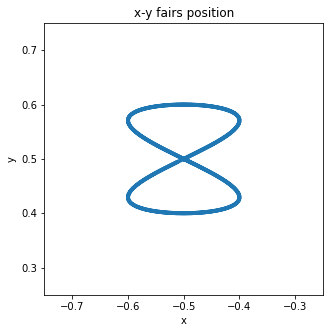

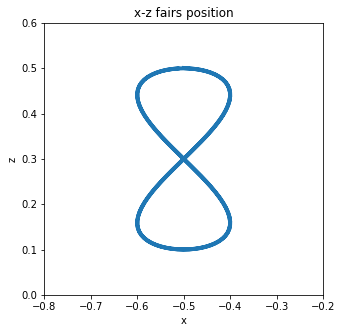

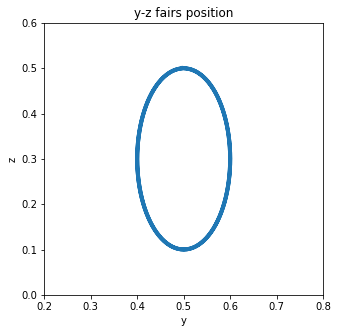

In [101]:
# x-y pairs
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("x")
plt.ylabel("y")
        
ax.set_ylim(0.25,0.75)
ax.set_xlim(-0.75,-0.25)

#plt.scatter(x,y)
plt.plot(x,y,linewidth = 4)
plt.title("x-y fairs position")  

#------------------------------------------------------------------------------------------------
# x-z pairs
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("x")
plt.ylabel("z")
        
ax.set_ylim(0,0.6)
ax.set_xlim(-0.80,-0.20)

#plt.scatter(x,z)
plt.plot(x,z,linewidth = 4)
plt.title("x-z fairs position") 

#------------------------------------------------------------------------------------------------
# y-z pairs
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("y")
plt.ylabel("z")
        
ax.set_ylim(0,0.6)
ax.set_xlim(0.20,0.80)

#plt.scatter(y,z)
plt.plot(y,z,linewidth = 4)
plt.title("y-z fairs position")  

In [65]:
# now we plot the joint trajectories for each joint (each cross correspond to one data point)
"""
plt.figure(figsize=[10,15])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(joint_trajectory[i,:], 'x', linewidth=4)
    plt.ylabel(f'joint {i+1}', fontsize=30)
"""


"\nplt.figure(figsize=[10,15])\nfor i in range(7):\n    plt.subplot(7,1,i+1)\n    plt.plot(joint_trajectory[i,:], 'x', linewidth=4)\n    plt.ylabel(f'joint {i+1}', fontsize=30)\n"

## Question 5: computing velocities
The file ``joint_velocities.npy`` contains the velocities of each joint corresponding to the sequence joint configurations seen in the previous question. 
* Use the Jacobian to compute the linear velocity of the endeffector in: 1) the spatial frame. 2) the end-effector frame and 3) in a frame with same origin as the end-effector frame but oriented like the spatial frame
* Plot these velocities in each frame (one plot per dimension x,y,z)
* Compare these plots and relate them to the plot of the positions (Question 4), is there a frame that seems most intuitive to you? Why?

In [96]:
# we open the file and put all the data in the variable joint_trajectory 
# this gives us a 7 x 200 array (each column in one set of joint configurations)
with open('joint_velocity.npy', 'rb') as f:
    joint_velocities = np.load(f)
    
# now we plot the joint velocities for each joint (each cross correspond to one data point)
"""
plt.figure(figsize=[10,15])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(joint_velocities[i,:], 'b', linewidth=4)
    plt.ylabel(f'joint {i+1}', fontsize=30)
"""

"\nplt.figure(figsize=[10,15])\nfor i in range(7):\n    plt.subplot(7,1,i+1)\n    plt.plot(joint_velocities[i,:], 'b', linewidth=4)\n    plt.ylabel(f'joint {i+1}', fontsize=30)\n"

In [77]:
# Computing the linear velocity in the spatial frame
m1,config_number1 = joint_velocities.shape

linear_Velocity = np.array([ [], [], [] ])

for i in range(config_number):
    theta = joint_trajectory.T[i]
    dtheta = joint_velocities.T[i]
    dtheta = dtheta.reshape(-1,1)
    
    Jspace = get_space_jacobian(theta)
    
    V = Jspace @ dtheta
    w,v = getwvfromTwist(V)
    linear_Velocity  = np.hstack((linear_Velocity ,v))

# check if the result is correct
#print(dtheta)
#print(linear_Velocity.shape)

# Prepare to plot
v_x = linear_Velocity[0,:]
v_y = linear_Velocity[1,:]
v_z = linear_Velocity[2,:]


'\nfig, ax = plt.subplots(figsize=(10, 10)\nplt.xlabel("x")\nplt.ylabel("y")\n        \nax.set_ylim(0.25,0.75)\nax.set_xlim(-0.75,-0.25)\n\nplt.scatter(x,y)\nplt.plot(x,y)\nplt.title("x-y fairs position")  \n'

In [82]:
# Computing the linear velocity in the body frame & body_spatial frame(The third type)
# Initializing
Body_linear_Velocity = np.array([ [], [], [] ])
Body_spatial_linear_Velocity = np.array([ [], [], [] ])

for i in range(config_number):
    # Set basic value
    theta = joint_trajectory.T[i]
    dtheta = joint_velocities.T[i]
    dtheta = dtheta.reshape(-1,1)

    # Get forward_kinematics
    FK = forward_kinematics(theta)
    # Get Body Twist and linear velocity
    Jspace = get_space_jacobian(theta)
    Jbody = getJbody(Jspace,FK)

    V_body = Jbody @ dtheta
    w_body, v_body = getwvfromTwist(V_body)

    Body_linear_Velocity = np.hstack((Body_linear_Velocity,v_body))
    # Get Body_Spatial Twist and linear velocity
    R,p = getRpfromT(FK)
    p = np.array([ [0], [0], [0] ])
    Tah = getTfromRp(R,p)
    Ad_Tah = getAdjoint(Tah)

    V_body_spatial = Ad_Tah @ V_body
    w_body_spatial, v_body_spatial = getwvfromTwist(V_body_spatial)

    Body_spatial_linear_Velocity = np.hstack((Body_spatial_linear_Velocity,v_body_spatial))

# check if the result is correct
print(Body_linear_Velocity.shape)

# Prepare to plot
v_x_body = Body_linear_Velocity[0,:]
v_y_body = Body_linear_Velocity[1,:]
v_z_body = Body_linear_Velocity[2,:]

#------------------------------------------------------------------------------------------------------------------
v_x_body_spatial = Body_spatial_linear_Velocity[0,:]
v_y_body_spatial = Body_spatial_linear_Velocity[1,:]
v_z_body_spatial = Body_spatial_linear_Velocity[2,:]


(3, 200)


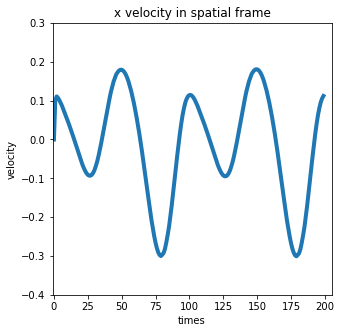

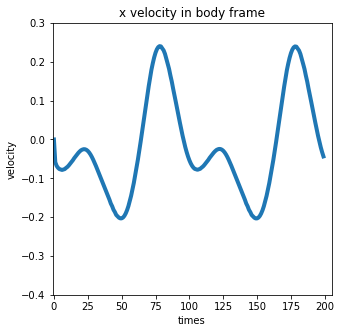

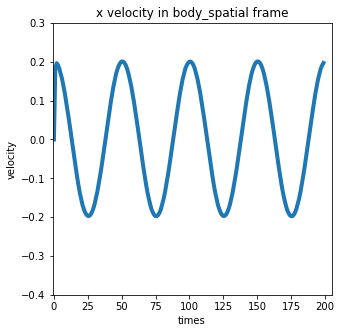

In [98]:
# Try to plot 'x' velocity in spatial frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("x velocity in spatial frame")        

ax.set_ylim(-0.4,0.3)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_x)
plt.plot(n,v_x,linewidth = 4)
#-----------------------------------------------------------------------------------------
# Try to plot 'x' velocity in body frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("x velocity in body frame")        

ax.set_ylim(-0.4,0.3)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_x_body)
plt.plot(n,v_x_body,linewidth = 4)

#-----------------------------------------------------------------------------------------
# Try to plot 'x' velocity in body_spatial frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("x velocity in body_spatial frame")        

ax.set_ylim(-0.4,0.3)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_x_body_spatial)
plt.plot(n,v_x_body_spatial,linewidth = 4)

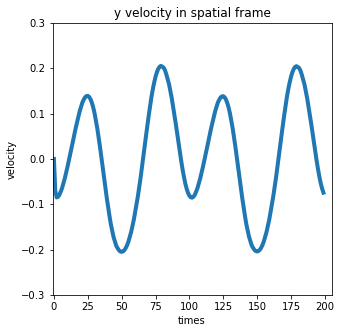

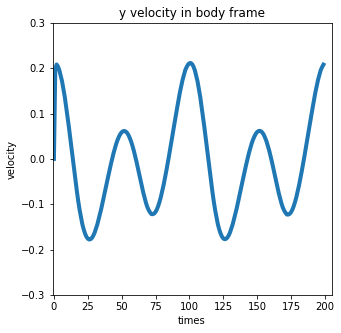

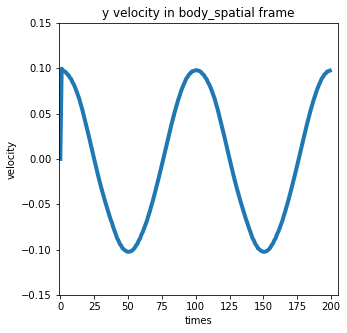

In [102]:
# Try to plot 'y' velocity in spatial frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("y velocity in spatial frame")        

ax.set_ylim(-0.3,0.3)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_y)
plt.plot(n,v_y,linewidth = 4)

#-----------------------------------------------------------------------------------------
# Try to plot 'y' velocity in body frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("y velocity in body frame")        

ax.set_ylim(-0.3,0.3)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_y_body)
plt.plot(n,v_y_body,linewidth = 4)

#-----------------------------------------------------------------------------------------
# Try to plot 'x' velocity in body_spatial frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("y velocity in body_spatial frame")        

ax.set_ylim(-0.15,0.15)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_y_body_spatial)
plt.plot(n,v_y_body_spatial,linewidth = 4)

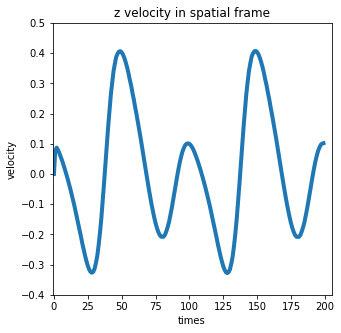

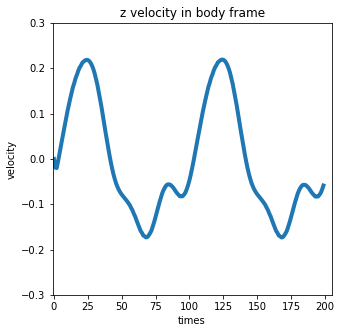

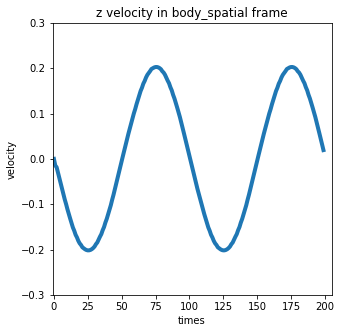

In [99]:
# Try to plot 'x' velocity in spatial frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("z velocity in spatial frame")        

ax.set_ylim(-0.4,0.5)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_z)
plt.plot(n,v_z,linewidth = 4)

#-----------------------------------------------------------------------------------------
# Try to plot 'x' velocity in body frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("z velocity in body frame")        

ax.set_ylim(-0.3,0.3)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_z_body)
plt.plot(n,v_z_body,linewidth = 4)

#-----------------------------------------------------------------------------------------
# Try to plot 'x' velocity in body_spatial frame
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("times")
plt.ylabel("velocity")
plt.title("z velocity in body_spatial frame")        

ax.set_ylim(-0.3,0.3)
ax.set_xlim(-1,205)
n = list(range(200))

#plt.scatter(n,v_z_body_spatial)
plt.plot(n,v_z_body_spatial,linewidth = 4)